<a href="https://colab.research.google.com/github/joaohnt/estudo_ml/blob/main/classificacao_de_sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy --upgrade

In [2]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 68.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np

# carregamento e pre processamento da base de dados

In [8]:
base_dados = pd.read_csv('/content/base_treinamento.txt', encoding = 'utf-8')

In [9]:
base_dados.shape

(196, 2)

In [10]:
base_dados.head()

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria


In [11]:
base_dados.tail()

,texto,emocao
191,estou chocado e amedrontado com este assassina...,medo
192,é preciso afugenta com ímpeto este medo do inf...,medo
193,políticos usam suas forças para afugentar e am...,medo
194,o objetivo disso e apenas me amedrontar mais,medo
195,isso me apavora,medo


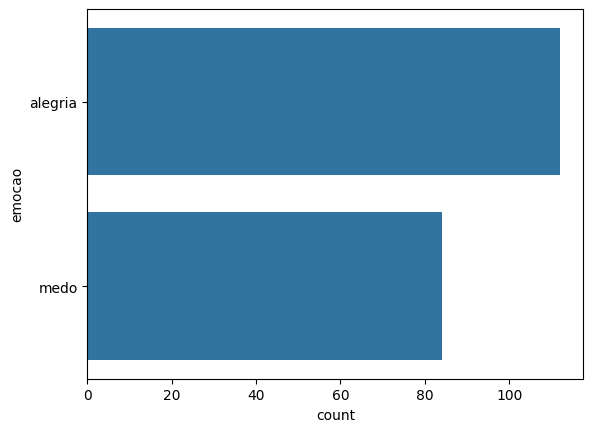

In [12]:
sns.countplot(base_dados['emocao'], label = 'Contagem');

removendo pontuacao e stop words

In [13]:
pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS

In [15]:
len(stop_words)

416

In [16]:
pln = spacy.load("pt_core_news_sm")

In [17]:
def preprocessamento(texto):
  texto = texto.lower()
  doc = pln(texto)

  lista = []
  for token in doc:
    lista.append(token.lemma_)

  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in pontuacoes]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return lista

In [18]:
teste = preprocessamento('Twice é o mElhor grupo de kpop. tmj! nota 10')
teste

'twice kpop tmj nota'

In [19]:
base_dados['texto'] = base_dados['texto'].apply(preprocessamento) # esse aply eh pra passar uma funcao

In [20]:
base_dados.head()

,texto,emocao
0,trabalho agradável,alegria
1,gostar ficar em o aconchego,alegria
2,fiz adesão a o curso hoje,alegria
3,admirar,alegria
4,adorar,alegria


In [21]:
exemplo_base_dados = [["este trabalho é agradável", {"ALEGRIA": True, "MEDO": False}],
                      ["este lugar continua assustador", {"ALEGRIA": False, "MEDO": True}]]

In [22]:
exemplo_base_dados[0]

['este trabalho é agradável', {'ALEGRIA': True, 'MEDO': False}]

In [23]:
base_dados_final = []
i = 0
for texto, emocao in zip(base_dados['texto'], base_dados['emocao']):
  if emocao == 'alegria':
    dic = ({'ALEGRIA': True, 'MEDO': False})
  elif emocao == 'medo':
    dic = ({'ALEGRIA': False, 'MEDO': True})
  else:
    dic = ({'ALEGRIA': False, 'MEDO': False})
  base_dados_final.append([texto, dic.copy()])

In [24]:
len(base_dados_final)

196

In [25]:
base_dados_final[2]

['fiz adesão a o curso hoje', {'ALEGRIA': True, 'MEDO': False}]

In [26]:
base_dados_final[150]

['ei cuidado bater em o poste', {'ALEGRIA': False, 'MEDO': True}]

#treinamento

In [29]:
modelo = spacy.blank('pt')
textcat = modelo.add_pipe("textcat")
textcat.add_label("ALEGRIA")
textcat.add_label("MEDO")
historico = []

In [30]:
!pip install spacy --upgrade
import spacy
from spacy.training import Example

modelo.begin_training()
for epoca in range(1000):
  random.shuffle(base_dados_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_final, 30):
    examples = []
    for texto, entities in batch:
      doc = modelo.make_doc(texto)
      example = Example.from_dict(doc, {"cats": entities})
      examples.append(example)

    modelo.update(examples, losses=losses)

  if epoca % 100 == 0:
    print(losses)
    historico.append(losses)

{'textcat': 1.7182927131652832}
{'textcat': 3.58769875787035e-11}
{'textcat': 4.798006935334553e-12}
{'textcat': 1.082635547780108e-12}
{'textcat': 3.8741282927458494e-13}
{'textcat': 1.60305535528869e-13}
{'textcat': 7.731132840375064e-14}
{'textcat': 3.605448446613072e-14}
{'textcat': 1.9941138164858397e-14}
{'textcat': 9.391244603923764e-15}


In [32]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [33]:
historico_loss = np.array(historico_loss)
historico_loss

array([1.71829271e+00, 3.58769876e-11, 4.79800694e-12, 1.08263555e-12,
       3.87412829e-13, 1.60305536e-13, 7.73113284e-14, 3.60544845e-14,
       1.99411382e-14, 9.39124460e-15])

Text(0, 0.5, 'Erro')

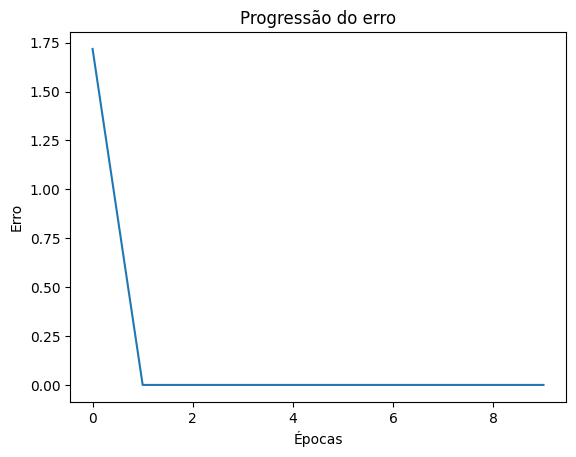

In [34]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')

In [35]:
modelo.to_disk("modelo")

In [37]:
modelo_carregado = spacy.load("modelo")
modelo_carregado

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [92]:
texto_positivo = 'eu gosto muito de ouvir música'

In [93]:
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'gostar ouvir música'

In [94]:
previsao = modelo_carregado(texto_positivo)

In [95]:
previsao.cats

{'ALEGRIA': 0.8507819771766663, 'MEDO': 0.14921808242797852}

In [97]:
texto_negativo = 'estou com medo do kanye west'
previsao = modelo_carregado(preprocessamento(texto_negativo))
previsao.cats

{'ALEGRIA': 0.009081101976335049, 'MEDO': 0.9909188747406006}

# avaliacao do modelo

na base de treinamento

In [108]:
previsoes = []
for texto in base_dados['texto']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [109]:
previsoes

[{'ALEGRIA': 1.0, 'MEDO': 1.0873253408760775e-08},
 {'ALEGRIA': 1.0, 'MEDO': 3.750659161028125e-08},
 {'ALEGRIA': 1.0, 'MEDO': 1.3789773767314273e-08},
 {'ALEGRIA': 1.0, 'MEDO': 1.8528513834326077e-08},
 {'ALEGRIA': 1.0, 'MEDO': 5.04074026963508e-09},
 {'ALEGRIA': 1.0, 'MEDO': 5.483424825314387e-09},
 {'ALEGRIA': 1.0, 'MEDO': 3.125543202031622e-08},
 {'ALEGRIA': 1.0, 'MEDO': 2.054560432895869e-08},
 {'ALEGRIA': 1.0, 'MEDO': 6.374450745028071e-09},
 {'ALEGRIA': 1.0, 'MEDO': 3.4785120561764415e-08},
 {'ALEGRIA': 1.0, 'MEDO': 4.276030196592728e-09},
 {'ALEGRIA': 1.0, 'MEDO': 1.295555396296777e-08},
 {'ALEGRIA': 1.0, 'MEDO': 2.0332120431731937e-09},
 {'ALEGRIA': 1.0, 'MEDO': 4.34761160406083e-09},
 {'ALEGRIA': 1.0, 'MEDO': 5.810209557921553e-08},
 {'ALEGRIA': 1.0, 'MEDO': 6.696569077035974e-09},
 {'ALEGRIA': 1.0, 'MEDO': 1.3211280069924669e-08},
 {'ALEGRIA': 1.0, 'MEDO': 3.099722256649784e-09},
 {'ALEGRIA': 1.0, 'MEDO': 3.480370480701822e-08},
 {'ALEGRIA': 1.0, 'MEDO': 6.9946648473262485e-

In [110]:
previsoes_final = []
for previsao in previsoes:
  if previsao['ALEGRIA'] > previsao['MEDO']:
    previsoes_final.append('alegria')
  else:
    previsoes_final.append('medo')

previsoes_final = np.array(previsoes_final)

In [111]:
previsoes_final

array(['alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 

In [112]:
respostas_reais = base_dados['emocao'].values
respostas_reais

array(['alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 

In [115]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(respostas_reais, previsoes_final) # overfitting </3

1.0

In [118]:
confusion_matrix(respostas_reais, previsoes_final)

array([[112,   0],
       [  0,  84]])

base de dados teste

In [121]:
base_dados_teste = pd.read_csv('/content/base_teste.txt', encoding = 'utf-8')

In [122]:
base_dados_teste.head()

,texto,emocao
0,não precisei pagar o ingresso,alegria
1,se eu ajeitar tudo fica bem,alegria
2,minha fortuna ultrapassará a sua,alegria
3,sou muito afortunado,alegria
4,é benéfico para todos esta nova medida,alegria


In [123]:
base_dados_teste['texto'] = base_dados_teste['texto'].apply(preprocessamento)

In [124]:
base_dados_teste.head()

,texto,emocao
0,precisar pagar ingresso,alegria
1,ajeitar ficar,alegria
2,fortuna ultrapassar,alegria
3,afortunar,alegria
4,benéfico medida,alegria


In [125]:
previsoes = []
for texto in base_dados_teste['texto']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [126]:
previsoes_final = []
for previsao in previsoes:
  if previsao['ALEGRIA'] > previsao['MEDO']:
    previsoes_final.append('alegria')
  else:
    previsoes_final.append('medo')

previsoes_final = np.array(previsoes_final)

In [127]:
previsoes_final

array(['medo', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'medo', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'medo', 'alegria',
       'alegria', 'alegria', 'alegria', 'medo', 'alegria', 'alegria',
       'medo', 'medo', 'alegria', 'alegria', 'medo', 'medo', 'alegria',
       'alegria', 'alegria', 'medo', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'medo',
       'medo', 'alegria', 'alegria', 'medo', 'medo', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'medo',
       'medo', 'medo', 'alegria', 'alegria', 'alegria', 'alegria', 'medo',
       'medo', 'medo', 'medo', 'alegria', 'alegria', 'alegria', 'alegria',
       'medo', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'medo', 'medo', 'medo', 'alegria', 'alegria', 'medo',
       'alegria'], dtype='<U7')

In [128]:
respostas_reais = base_dados_teste['emocao'].values
respostas_reais

array(['alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'medo', 'medo', 'medo', 'medo', 'medo', 'medo', 'medo', 'medo',
       'medo', 'medo', 'medo', 'medo', 'medo', 'medo', 'medo', 'medo',
       'medo', 'medo', 'medo', 'medo', 'medo', 'medo', 'medo', 'medo',
       'medo', 'medo', 'medo', 'medo', 'medo', 'medo', 'medo', 'medo',
       'medo', 'medo', 'medo', 'medo'], dtype=object)

In [129]:
accuracy_score(respostas_reais, previsoes_final)

0.5595238095238095

In [130]:
confusion_matrix(respostas_reais, previsoes_final)

array([[35, 13],
       [24, 12]])